# II. US Kidney Recipient Candidates

In [3]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from matplotlib import pyplot as plt
import scipy as sp

## Characterizing the distribution

In [45]:
included_rows = [
    0, # WL_ORG - Organ type
    54, # INIT_AGE - Initial age of recipient at listing
    61, # INIT_DATE - Initial date of recipient listing
    24, # GENDER - Recipient gender
    63, # ETHCAT - Recipient ethnicity
    385, # HGT_CM_CALC - Recipient height (cm)
    386, # WGT_KG_CALC - Recipient weight (kg)
    33, # EDUCATION - Recipient highest education at listing
    32, # PERM_STATE - Recipient state of residency
    103, # PRI_PAYMENT_TCR_KI - Recipient primary projected payment source at listing
    6, # CREAT_CLEAR - Recipient CrCl at listing
    7, # GFR - Recipient GFR at listing
    37, # DIAB - Recipient diabetes at listing
    8, # DONATION - Receives allocation points for previously donating an organ
    2, # NUM_PREV_TX - Recipient number of previous transplants
    47, # INIT_CPRA - Recipient CPRA at listing
    48, # END_CPRA - Recipient most recent CPRA
    58, # DIALYSIS_DATE - Date recipient started regular dialysis for ESRD
    118, # TX_DATE - Transplant date
    68, # COMPOSITE_DEATH_DATE - Death date
    67, # DAYSWAIT_ALLOC - official waiting time for allocation priority as measured by the OPTN standards
    194, # DON_TY - Decreased or living donor
    64, # PT_CODE - Encrypted patient identifier
    414, # TRR_ID_CODE - Encrypted transplant identifier
    99, # WORK_INCOME_TCR - Do they work for an income?
]
kidpan_data = pd.read_csv(
    "C:/Users/brand/Desktop/STAR_Delimited/Delimited Text File 202312/Kidney_ Pancreas_ Kidney-Pancreas/KIDPAN_DATA.DAT",
    sep="\t",
    usecols=included_rows
)
colnames = pd.read_csv(
    "C:/Users/brand/Desktop/STAR_Delimited/Analysis/KIDPAN_DATA_colnames.csv",
    sep=",",
    header=0,
    skiprows=lambda x : x-1 not in included_rows + [-1]
)
kidpan_data.columns = list(colnames["LABEL"])
kidpan_data = kidpan_data[kidpan_data["WL_ORG"] == "KI"]
kidpan_data = kidpan_data[kidpan_data["DON_TY"] != "F"]

C:\Users\brand\AppData\Local\Temp\ipykernel_8464\2378728326.py:28: DtypeWarning: Columns (2,8,33,37,47,48,54,67,99,103,194,385,386,414) have mixed types. Specify dtype option on import or set low_memory=False.
  kidpan_data = pd.read_csv(


In [47]:
kidpan_data = kidpan_data.replace(".", np.nan)

for numeric_column in ["INIT_AGE", "HGT_CM_CALC", "WGT_KG_CALC", "CREAT_CLEAR", "GFR", "NUM_PREV_TX", "INIT_CPRA", "END_CPRA", "DAYSWAIT_ALLOC", "DIAB"]:
    kidpan_data[numeric_column] = kidpan_data[numeric_column].astype(float)
for date_column in ["INIT_DATE", "DIALYSIS_DATE", "TX_DATE", "COMPOSITE_DEATH_DATE"]:
    kidpan_data[date_column] = pd.to_datetime(kidpan_data[date_column].replace(".", np.nan))

kidpan_data = kidpan_data.replace({
    "ETHCAT" : {
        1 : "White, Non-Hispanic",
        2 : "Black, Non-Hispanic",
        4 : "Hispanic/Latino",
        5 : "Asian, Non-Hispanic",
        6 : "Amer Ind/Alaska Native, Non-Hispanic",
        7 : "Native Hawaiian/other Pacific Islander, Non-Hispanic",
        9 : "Multiracial, Non-Hispanic",
        998 : np.nan,
    },
    "EDUCATION" : {
        1 : "None",
        2 : "Grade School (0-8)",
        3 : "High School (9-12) or GED",
        4 : "Attended College/Technical School",
        5 : "Associate/Bachelor Degree",
        6 : "Post-College Graduate Degree",
        996 : np.nan,
        998 : np.nan,
    },
    "PRI_PAYMENT_TCR_KI" : {
        1 : "Private insurance",
        2 : "Public insurance - Medicaid",
        3 : "Public insurance - Medicare FFS (Fee for Service)",
        4 : "Public insurance - Medicare & Choice",
        5 : "Public insurance - CHIP (Children's Health Insurance Program)",
        6 : "Public insurance - Department of VA",
        7 : "Public insurance - Other government",
        8 : "Self",
        9 : "Donation",
        10 : "Free Care",
        11 : "Pending",
        12 : "Foreign Government Specify",
        13 : "Public insurance - Medicare (further detail not collected)",
        14 : "US/State Govt Agency",
        15 : np.nan
    },
    "DIAB" : {
        1 : "No",
        2 : "Type I",
        3 : "Type II",
        4 : "Other",
        5 : np.nan,
        998 : np.nan,
    },
    "WORK_INCOME_TCR" : {
        "Y" : True,
        "N" : False,
        "U" : np.nan,
    }
})
kidpan_data["PERM_STATE"] = kidpan_data["PERM_STATE"].replace("ZZ", np.nan)
kidpan_data["DONATION"] = (kidpan_data["DONATION"] == "Y")
kidpan_data["DIAB"] = (kidpan_data["DIAB"] != "No")
kidpan_data["WORK_INCOME_TCR"] = kidpan_data["WORK_INCOME_TCR"].astype(bool)

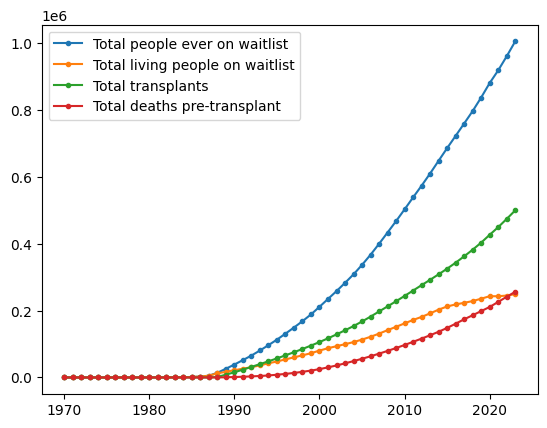

In [4]:
# Create plot of total waitlist size over year
dates = np.linspace(1970,2023,2023-1970+1)
total_size = np.zeros(len(dates))
waitlist_size = np.zeros(len(dates))
total_transplants = np.zeros(len(dates))
total_deaths_pretransplant = np.zeros(len(dates))
for i in range(len(dates)):
    total_size[i] = np.sum(kidpan_data["INIT_DATE"].dt.year < dates[i])
    waitlist_size[i] = np.sum(
        (kidpan_data["INIT_DATE"].dt.year < dates[i]) &
        (np.isnan(kidpan_data["COMPOSITE_DEATH_DATE"]) | (kidpan_data["COMPOSITE_DEATH_DATE"].dt.year >= dates[i])) &
        (np.isnan(kidpan_data["TX_DATE"]) | (kidpan_data["TX_DATE"].dt.year >= dates[i]))
    )
    total_transplants[i] = np.sum(
        (kidpan_data["INIT_DATE"].dt.year < dates[i]) &
        (kidpan_data["TX_DATE"].dt.year < dates[i])
    )
    total_deaths_pretransplant[i] = np.sum(
        (kidpan_data["INIT_DATE"].dt.year < dates[i]) &
        (kidpan_data["COMPOSITE_DEATH_DATE"].dt.year < dates[i]) &
        np.isnan(kidpan_data["TX_DATE"])
    )

plt.plot(dates,total_size, marker=".", label="Total people ever on waitlist")
plt.plot(dates,waitlist_size, marker=".", label="Total living people on waitlist")
plt.plot(dates,total_transplants, marker=".", label="Total transplants")
plt.plot(dates,total_deaths_pretransplant, marker=".", label="Total deaths pre-transplant")
plt.legend()
plt.show()

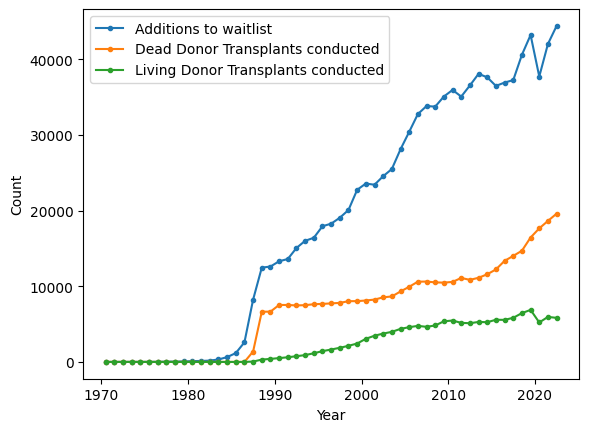

In [5]:
kidpan_data["INIT_DATE_YEARS_SINCE_1970"] = (kidpan_data["INIT_DATE"] - pd.Timestamp(year=1970, month=1, day=1)).dt.days / 365
kidpan_data["IS_WHITE"] = (kidpan_data["ETHCAT"] == "White, Non-Hispanic")
kidpan_data["IS_MALE"] = (kidpan_data["GENDER"] == "M")
kidpan_data["ATTENDED_COLLEGE"] = ((kidpan_data["EDUCATION"] == "Attended College/Technical School") | (kidpan_data["EDUCATION"] == "Associate/Bachelor Degree") | (kidpan_data["EDUCATION"] == "Post-College Graduate Degree"))

# Group by 'years_since_first' with bin size 1 and calculate mean of 'INIT_AGE'
year_groupings = kidpan_data.groupby(
    pd.cut(
        kidpan_data['INIT_DATE_YEARS_SINCE_1970'],
        bins=np.arange(kidpan_data['INIT_DATE_YEARS_SINCE_1970'].min(), kidpan_data['INIT_DATE_YEARS_SINCE_1970'].max() + 1, 1)
    ),
    dropna=True
)
yearly_means = year_groupings.mean(numeric_only=True)
yearly_stes = year_groupings.sem(numeric_only=True)
# Create plot of annual waitlist additions
n_wait,x_wait,_ = plt.hist(kidpan_data["INIT_DATE_YEARS_SINCE_1970"] + 1970, bins=np.arange(1970,2023+1,1))
bin_centers_wait = 0.5*(x_wait[1:]+x_wait[:-1])

# Create plot of annual transplants conducted
kidpan_data["TX_DATE_YEARS_SINCE_1970"] = (kidpan_data["TX_DATE"] - pd.Timestamp(year=1970, month=1, day=1)).dt.days / 365
n_trans_dd,x_trans_dd,_ = plt.hist(kidpan_data["TX_DATE_YEARS_SINCE_1970"][kidpan_data["DON_TY"] == "C"] + 1970, bins=np.arange(1970,2023+1,1))
bin_centers_trans_dd = 0.5*(x_trans_dd[1:]+x_trans_dd[:-1])
n_trans_ld,x_trans_ld,_ = plt.hist(kidpan_data["TX_DATE_YEARS_SINCE_1970"][kidpan_data["DON_TY"] == "L"] + 1970, bins=np.arange(1970,2023+1,1))
bin_centers_trans_ld = 0.5*(x_trans_ld[1:]+x_trans_ld[:-1])

# Output plots together
plt.close()
plt.plot(bin_centers_wait,n_wait, marker=".", label="Additions to waitlist")
plt.plot(bin_centers_trans_dd,n_trans_dd, marker=".", label="Dead Donor Transplants conducted")
plt.plot(bin_centers_trans_ld,n_trans_ld, marker=".", label="Living Donor Transplants conducted")
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend()
plt.show()

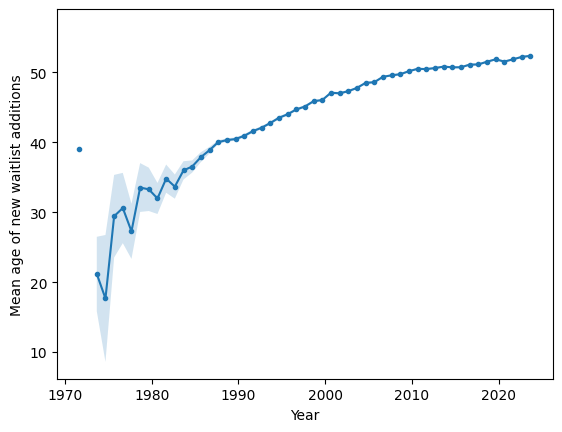

In [6]:
# Plotting annual age means
plt.plot(yearly_means.index.categories.mid + 1970, yearly_means["INIT_AGE"], marker='.', linestyle='-')
plt.fill_between(
    yearly_means.index.categories.mid + 1970,
    yearly_means['INIT_AGE'] - yearly_stes['INIT_AGE']*1.96,
    yearly_means['INIT_AGE'] + yearly_stes['INIT_AGE']*1.96,
    alpha=0.2)
plt.xlabel('Year')
plt.ylabel('Mean age of new waitlist additions')
plt.show()

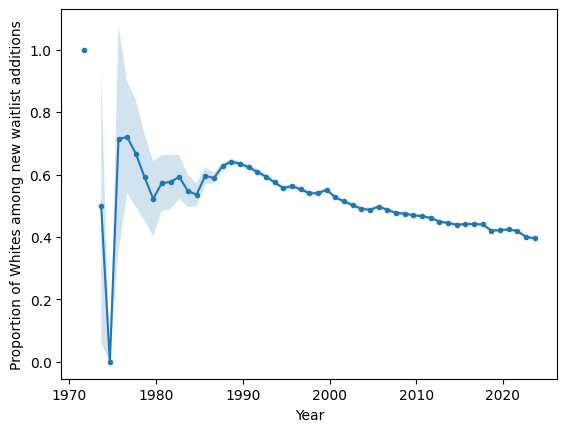

In [7]:
# Plotting annual age means
plt.plot(yearly_means.index.categories.mid + 1970, yearly_means['IS_WHITE'], marker='.', linestyle='-')
plt.fill_between(
    yearly_means.index.categories.mid + 1970,
    yearly_means['IS_WHITE'] - yearly_stes['IS_WHITE']*1.96,
    yearly_means['IS_WHITE'] + yearly_stes['IS_WHITE']*1.96,
    alpha=0.2)
plt.xlabel('Year')
plt.ylabel('Proportion of Whites among new waitlist additions')
plt.show()

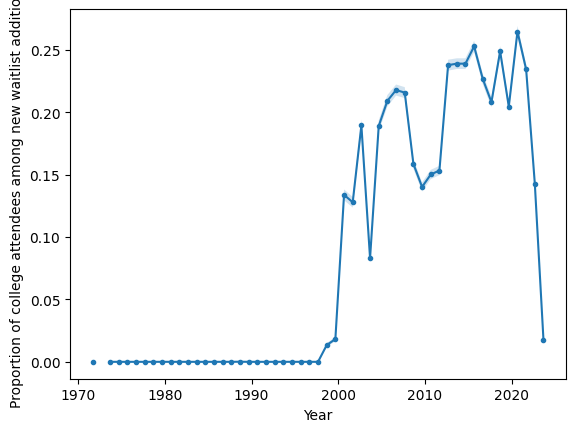

In [8]:
# Plotting annual age means
plt.plot(yearly_means.index.categories.mid + 1970, yearly_means['ATTENDED_COLLEGE'], marker='.', linestyle='-')
plt.fill_between(
    yearly_means.index.categories.mid + 1970,
    yearly_means['ATTENDED_COLLEGE'] - yearly_stes['ATTENDED_COLLEGE']*1.96,
    yearly_means['ATTENDED_COLLEGE'] + yearly_stes['ATTENDED_COLLEGE']*1.96,
    alpha=0.2)
plt.xlabel('Year')
plt.ylabel('Proportion of college attendees among new waitlist additions')
plt.show()

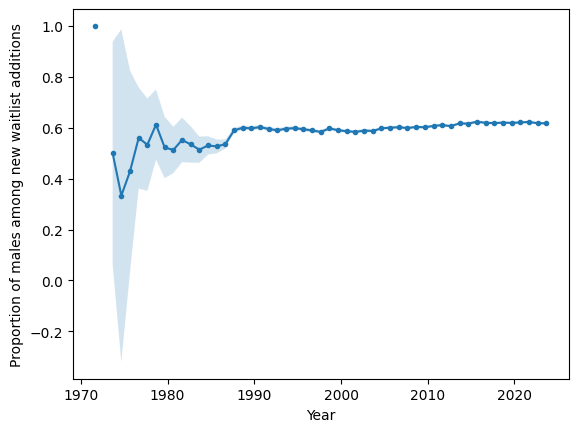

In [9]:
# Plotting annual age means
plt.plot(yearly_means.index.categories.mid + 1970, yearly_means['IS_MALE'], marker='.', linestyle='-')
plt.fill_between(
    yearly_means.index.categories.mid + 1970,
    yearly_means['IS_MALE'] - yearly_stes['IS_MALE']*1.96,
    yearly_means['IS_MALE'] + yearly_stes['IS_MALE']*1.96,
    alpha=0.2)
plt.xlabel('Year')
plt.ylabel('Proportion of males among new waitlist additions')
plt.show()

We ultimately choose to restrict our population pool to the last 10 years; that is, 2013-2023 (inclusive). We also drop any rows with missing values for GFR, as we will rely on them for estimating our outcomes.

In [48]:
kidpan_data = kidpan_data[kidpan_data["INIT_DATE"].dt.year >= 2013]
kidpan_data = kidpan_data[~np.isnan(kidpan_data["GFR"])]

## Mortality, Income, and Costs Modeling

For the purposes of simplifying our model, we restrict our data to White non-Hispanic, Black non-Hispanic, and Hispanic peoples.

In [90]:
kidpan_data = kidpan_data[
    (kidpan_data["ETHCAT"] == "White, Non-Hispanic") |
    (kidpan_data["ETHCAT"] == "Black, Non-Hispanic") |
    (kidpan_data["ETHCAT"] == "Hispanic/Latino")
].replace({"ETHCAT" : {
    "White, Non-Hispanic" : "White",
    "Black, Non-Hispanic" : "Black",
    "Hispanic/Latino" : "Hispanic",
}})

### Mortality Rate: Dialysis
We model mortality rates according to the "Gompertz–Makeham Law of Mortality," which models human mortality as the sum of an age-dependent component, which increases exponentially with age, and an age-independent component. The hazard function (that is, the mortality rate function over age) of the Gompertz-Makeham distribution is modeled as $\alpha e^{\beta x} + \gamma$, where $x$ is a person's age.

We can use existing research on the mortality rates of patients both on dialsyis and who receive transplants to estimate the parameters for the Gompertz-Makeham distribution based on a given person's age, gender, and race. An [analysis](<https://journals.lww.com/cjasn/fulltext/2013/06000/the_relationship_of_age,_race,_and_ethnicity_with.11.aspx>) of 1.2 million dialysis patients ages 18 or older between 1995 and 2009 found the following annual mortality rates over age for (non-Hispanic) Whites, (non-Hispanic) Blacks, and Hispanics:

In [11]:
mortality_rate_dialysis_table = pd.DataFrame(data={
    "Age bin lower bound" : [18, 31, 41, 51, 61, 71, 80],
    "Age bin upper bound" : [30, 40, 50, 60, 70, 80, 100],
    "White count" : [40582, 84089, 176384, 302268, 418774, 438613, 161505],
    "White mortality (%)" : [6.9, 11.5, 15.5, 21.2, 29.4, 39.9, 56.7],
    "Black count" : [70994, 146611, 251712, 301372, 272866, 160121, 41636],
    "Black mortality (%)" : [7.1, 9.4, 11.9, 15.2, 21.2, 31.3, 48.6],
    "Hispanic count" : [29543, 40150, 77555, 120868, 120788, 68341, 15918],
    "Hispanic mortality (%)" : [3.3, 6.8, 10, 14.2, 20.8, 31.3, 49.7]
})
mortality_rate_dialysis_table

,Age bin lower bound,Age bin upper bound,White count,White mortality (%),Black count,Black mortality (%),Hispanic count,Hispanic mortality (%)
0,18,30,40582,6.9,70994,7.1,29543,3.3
1,31,40,84089,11.5,146611,9.4,40150,6.8
2,41,50,176384,15.5,251712,11.9,77555,10.0
3,51,60,302268,21.2,301372,15.2,120868,14.2
4,61,70,418774,29.4,272866,21.2,120788,20.8
5,71,80,438613,39.9,160121,31.3,68341,31.3
6,80,100,161505,56.7,41636,48.6,15918,49.7


We fit this data to our Gompertz-Makeham model for each race category weighted by the estimated standard errors of the mortality rates:

White fit:	h(Age) = 0.030377 exp(0.035875 Age) + 0.020246
Black fit:	h(Age) = 0.006207 exp(0.052413 Age) + 0.061768
Hispanic fit:	h(Age) = 0.015619 exp(0.042351 Age) + 0.005365


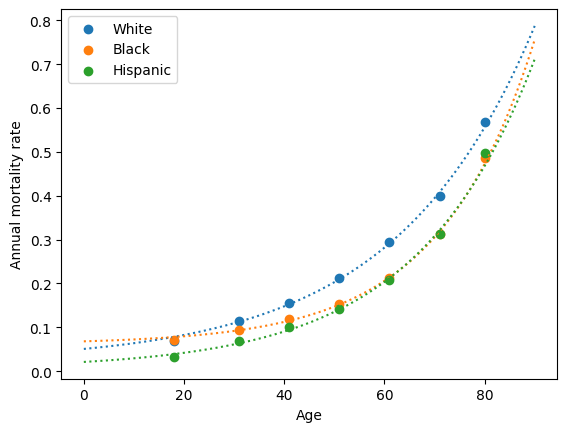

In [100]:
def gm_hazard(x, alpha, beta, gamma):
    return alpha * np.exp(beta * x) + gamma

for race in ["White", "Black", "Hispanic"]:
    xdata = mortality_rate_dialysis_table["Age bin lower bound"]
    ydata = mortality_rate_dialysis_table[race + " mortality (%)"]/100
    yerr = np.sqrt(ydata * (1 - ydata) / mortality_rate_dialysis_table[race + " count"])
    popt, pcov = sp.optimize.curve_fit(
        gm_hazard,
        xdata,
        ydata,
        sigma=yerr,
        bounds=(0,[1,1,1]),
    )
    plt.plot(np.linspace(0,90,100), gm_hazard(np.linspace(0,90,100), *popt), linestyle=":")
    plt.scatter(
        xdata,
        ydata,
        label=race,
    )
    print(race + " fit:\th(Age) = %5.6f exp(%5.6f Age) + %5.6f" % tuple(popt))
plt.legend()
plt.xlabel("Age")
plt.ylabel("Annual mortality rate")
plt.show()

We include the results of a regression from [this paper](<https://academic.oup.com/ckj/article/14/1/189/5809185>) to include estimated GFR and diabetes in our predictions, which predicts mortality within 2 years as $P_2 = e^\beta / (1 + e^\beta)$ where $\beta = 0.0049 GFR + 0.2792 Diabetes + C$.

Taking that the mortality rate is constant within those two years as a simplifying assumption, we can then calculate the 1 year mortality $P_1$ increase based on GFR and diabetes for the average person in the sample:

$$
\begin{align*}
P_2 &= P_1 + (1-P_1) P_1\\
P_1 &= 1 - \sqrt{1-P_2}\\
\frac{dP_1}{d(GFR)} &= 0.0064\\
\frac{dP_1}{d(Diabetes)} &= 0.0362
\end{align*}
$$

As the paper controlled for age in their logistic regression, the coefficients found are age-independent; we thus include these results in the age-independent $\gamma$ factor of the existing Gompertz-Makeham to get the following final models for mortality rate over age for patients on dialysis:

- White fit: $h(x) = (0.030377 \exp(0.035875 Age) + 0.020246)(1 - \beta) + \beta$
- Black fit: $h(x) = (0.006207 \exp(0.052413 Age) + 0.061768)(1 - \beta) + \beta$
- Hispanic fit: $h(x) = (0.015619 \exp(0.042351 Age) + 0.005365)(1 - \beta) + \beta$

where $\beta = 0.0064 GFR + 0.0362 Diabetes$.

### Mortality Rate: Transplant

If we estimated the mortality rate by simply regressing the death date on pre-transplant recipient candidate characteristics, we would get the average treatment effect on the treated (ATT) rather than the average treatment effect overall (ATE); because treatment is assigned based on maximizing predicted transplant outcomes, there is good reason to believe the ATT and ATE would be different. Unfortunately, there is little data where treatment is randomly assigned, so we will need to make do with the ATT.

In [308]:
transplant_recipient_mortality_sample = pd.DataFrame(columns=[
    "IS_ALIVE",
    "CURR_AGE",
    "ETHCAT",
    "AGE_OF_TRANSPLANT",
    "WAITLIST_TIME",
    "PRIOR_TRANSPLANT",
    "DIAB",
    "GFR",
])
snapshots = list()
for year in np.arange(2013,2023+1,1):
    # get snapshot at year of follow-up
    transplant_recipients_only = kidpan_data[kidpan_data["TX_DATE"].dt.year < year]
    snapshot = pd.DataFrame({
        "IS_ALIVE" : np.isnan(transplant_recipients_only["COMPOSITE_DEATH_DATE"]) | (transplant_recipients_only["COMPOSITE_DEATH_DATE"].dt.year >= year),
        "CURR_AGE" : year - transplant_recipients_only["INIT_DATE"].dt.year + transplant_recipients_only["INIT_AGE"],
        "ETHCAT" : transplant_recipients_only["ETHCAT"],
        "IS_WHITE" : transplant_recipients_only["ETHCAT"] == "White",
        "AGE_OF_TRANSPLANT" : (transplant_recipients_only["TX_DATE"] - transplant_recipients_only["INIT_DATE"]).dt.days/365 + transplant_recipients_only["INIT_AGE"],
        "WAITLIST_TIME" : transplant_recipients_only["DAYSWAIT_ALLOC"],
        "PRIOR_TRANSPLANT" : transplant_recipients_only["NUM_PREV_TX"] > 0,
        "DIAB" : transplant_recipients_only["DIAB"],
        "GFR" : transplant_recipients_only["GFR"],
    })
    snapshots.append(snapshot)
transplant_recipient_mortality_sample = pd.concat(snapshots)
transplant_recipient_mortality_sample = transplant_recipient_mortality_sample.dropna()

[1.51577568e-05 8.98202074e-02 2.90057931e-04]
[2.39711335e-05 8.26631287e-02 5.99200190e-04]
[4.63365887e-05 7.31423716e-02 6.31476884e-05]


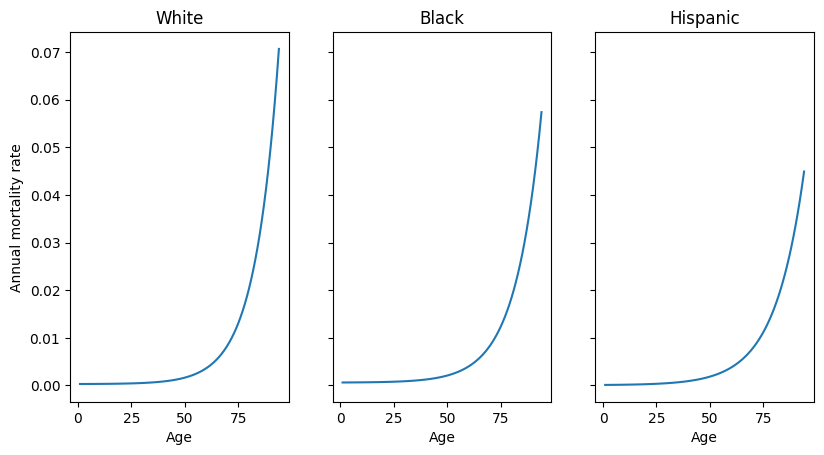

In [213]:
def gm_age_cdf(x, alpha, beta, gamma):
    return 1 - np.exp(-gamma * x - alpha/beta * (np.exp(beta * x) - 1))
def gm_age_pdf(x, alpha, beta, gamma):
    return alpha * np.exp(beta * x) + gamma

fig, axs = plt.subplots(1,3, sharex=True, sharey=True, figsize=plt.figaspect(0.5))
i = 0
for race in ["White", "Black", "Hispanic"]:
    xdata = transplant_recipient_mortality_sample[transplant_recipient_mortality_sample["ETHCAT"] == race]["CURR_AGE"]
    ydata = 1 - transplant_recipient_mortality_sample[transplant_recipient_mortality_sample["ETHCAT"] == race]["IS_ALIVE"]
    popt, pcov = sp.optimize.curve_fit(
        gm_age_cdf,
        xdata,
        ydata,
        bounds=(0,1)
    )
    print(popt)
    mymeans = transplant_recipient_mortality_sample.groupby("CURR_AGE").mean(numeric_only=True)
    axs[i].plot(mymeans.index, gm_age_pdf(mymeans.index, *popt), linestyle="-", label=race)
    axs[i].set_title(race)
    axs[i].set_xlabel("Age")
    if i == 0: axs[i].set_ylabel("Annual mortality rate")
    i += 1

plt.show()

In [310]:
def gm_since_hazard_cdf(x, alpha, beta, gamma1, gamma2, gamma3, gamma4):
    gamma = gamma1*x["WAITLIST_TIME"] + gamma2*x["PRIOR_TRANSPLANT"] + gamma3*x["DIAB"] + gamma4*x["GFR"]
    return 1 - np.exp(-gamma * (x["CURR_AGE"] - x["AGE_OF_TRANSPLANT"]) - alpha/beta * (np.exp(beta * (x["CURR_AGE"] - x["AGE_OF_TRANSPLANT"])) - 1))
def gm_since_hazard_pdf(x, alpha, beta, gamma1, gamma2, gamma3, gamma4):
    gamma = gamma1*x["WAITLIST_TIME"] + gamma2*x["PRIOR_TRANSPLANT"] + gamma3*x["DIAB"] + gamma4*x["GFR"]
    return alpha * np.exp(beta * (x["CURR_AGE"] - x["AGE_OF_TRANSPLANT"])) + gamma

def gm_since_hazard_age_cdf(x, alpha, beta, gamma0, gamma1, gamma2, gamma3, gamma4, gamma5):
    gamma = gamma0*x["AGE_OF_TRANSPLANT"] + gamma1*x["WAITLIST_TIME"] + gamma2*x["PRIOR_TRANSPLANT"] + gamma3*x["DIAB"] + gamma4*x["GFR"] + gamma5*x["IS_WHITE"]
    return 1 - np.exp(-gamma * x["CURR_AGE"] - alpha/beta * (np.exp(beta * x["CURR_AGE"]) - 1))
def gm_since_hazard_age_pdf(x, alpha, beta, gamma0, gamma1, gamma2, gamma3, gamma4, gamma5):
    gamma = gamma0*x["AGE_OF_TRANSPLANT"] + gamma1*x["WAITLIST_TIME"] + gamma2*x["PRIOR_TRANSPLANT"] + gamma3*x["DIAB"] + gamma4*x["GFR"] + gamma5*x["IS_WHITE"]
    return alpha * np.exp(beta * x["CURR_AGE"]) + gamma

# potrm = dict() # parameters optimal transplant recipient mortality
# for race in ["White", "Black", "Hispanic"]:
#     xdata = transplant_recipient_mortality_sample[transplant_recipient_mortality_sample["ETHCAT"] == race].loc[:, transplant_recipient_mortality_sample.columns!="IS_ALIVE"]
#     ydata = 1 - transplant_recipient_mortality_sample[transplant_recipient_mortality_sample["ETHCAT"] == race]["IS_ALIVE"]
#     potrm[race],_ = sp.optimize.curve_fit(
#         gm_since_hazard_age_cdf,
#         xdata,
#         ydata,
#         # bounds=([0,0,0,0,0,-1],[1,1,1,1,1,0])
#         bounds=([0,0,0,0,0,0,-1],[1,1,1,1,1,1,0]) # age only
#     )
#     print(race + " fit:\th(Age) = %5.6f exp(%5.6f Age) + %5.6f Age_of_transplant + %5.6f Waitlist_time + %5.6f Prior_transplant + %5.6f Diab + %5.6f GFR" % tuple(potrm[race]))
#     # print(race + " fit:\th(Age) = %5.6f exp(%5.6f (Age - Age_of_transplant)) + %5.6f Waitlist_time + %5.6f Prior_transplant + %5.6f Diab + %5.6f GFR" % tuple(potrm[race]))

xdata = transplant_recipient_mortality_sample.loc[:, transplant_recipient_mortality_sample.columns!="IS_ALIVE"]
ydata = 1 - transplant_recipient_mortality_sample["IS_ALIVE"]
popt,_ = sp.optimize.curve_fit(
    gm_since_hazard_age_cdf,
    xdata,
    ydata,
    bounds=([0,0,0,0,0,0,-1,-1],[1,1,1,1,1,1,0,1])
)
print("h(Age) = %5.6f exp(%5.6f Age) + %5.6f Age_of_transplant + %5.6f Waitlist_time + %5.6f Prior_transplant + %5.6f Diab + %5.6f GFR + %5.6f Is_white" % tuple(popt))


	h(Age) = 0.000023 exp(0.083532 Age) + 0.000000 Age_of_transplant + 0.000000 Waitlist_time + 0.000452 Prior_transplant + 0.000825 Diab + -0.000021 GFR + 0.000093 Is_white


### Income: Dialysis
Since the OPTN does not track income data, we instead measure changes in employment rates based on whether someone is on dialysis and their age, then calculate net income by multiplying the employment probability by the expected income based on their age, race, gender, and level of education.

A [study](<https://journals.lww.com/cjasn/fulltext/2018/02000/Employment_among_Patients_Starting_Dialysis_in_the.13.aspx>) of 480,597 patients who started dialysis in the US between 1996 and 2013 showed that patients starting dialysis were employed at about 23% compared to 83% employment of similarly aged adults in the general population. Based on this, we will model the effect of dialysis on employment as making it 3.61 times less likely to be employed compared to adults with similar demographic characteristics.

### Income: Transplant

To find the effect of a transplant on employment compared to being on dialysis, we run a logistic regression of the probability of being employed over time and whether someone was employed when they started dialysis.

In [49]:
included_rows = {
    "WORK_INCOME_FOLLOW_UP" : 10,
    "PT_CODE" : 48,
    "PX_STAT_DATE" : 51,
    "TRR_ID_CODE" : 54,
}
kidpan_followup_data = pd.read_csv(
    "C:/Users/brand/Desktop/STAR_Delimited/Delimited Text File 202312/Kidney_ Pancreas_ Kidney-Pancreas/Individual Follow-up Records/KIDNEY_FOLLOWUP_DATA.DAT",
    sep="\t",
    usecols=list(included_rows.values()),
)
kidpan_followup_data.columns = list(included_rows.keys())
kidpan_followup_data = kidpan_followup_data.replace(".", np.nan)
kidpan_followup_data["PX_STAT_DATE"] = pd.to_datetime(kidpan_followup_data["PX_STAT_DATE"])
kidpan_followup_data = kidpan_followup_data.replace({
    "WORK_INCOME_FOLLOW_UP" : {
        "Y" : True,
        "N" : False,
        "U" : np.nan,
    }
})
kidpan_followup_data["WORK_INCOME_FOLLOW_UP"] = kidpan_followup_data["WORK_INCOME_FOLLOW_UP"].astype(bool)

C:\Users\brand\AppData\Local\Temp\ipykernel_8464\1516102738.py:1: FutureWarning: Passing 'suffixes' which cause duplicate columns {'PT_CODE_y'} in the result is deprecated and will raise a MergeError in a future version.
  kidpan_followup_data = kidpan_data.merge(kidpan_followup_data, how="inner", on="TRR_ID_CODE")


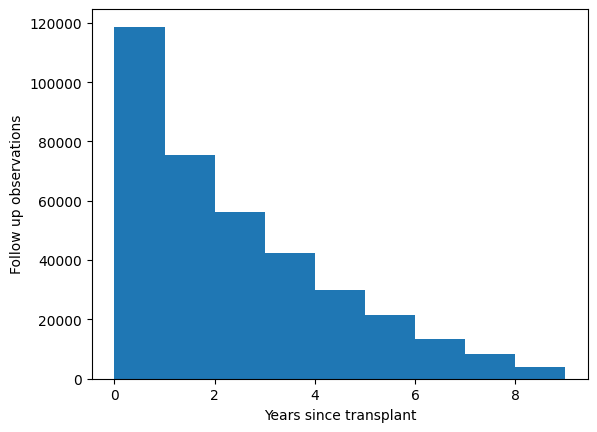

In [67]:
kidpan_followup_data = kidpan_data.merge(kidpan_followup_data, how="inner", on="TRR_ID_CODE")
kidpan_followup_data["TIME_SINCE_TRANSPLANT"] = (kidpan_followup_data["PX_STAT_DATE"] - kidpan_followup_data["TX_DATE"]).dt.days/365
plt.hist(kidpan_followup_data["TIME_SINCE_TRANSPLANT"], bins=np.arange(10))
plt.xlabel("Years since transplant")
plt.ylabel("Follow up observations")
plt.show()

Optimization terminated successfully.
         Current function value: 0.542565
         Iterations 6
                             Logit Regression Results                            
Dep. Variable:     WORK_INCOME_FOLLOW_UP   No. Observations:               371754
Model:                             Logit   Df Residuals:                   371751
Method:                              MLE   Df Model:                            2
Date:                   Thu, 11 Apr 2024   Pseudo R-squ.:                  0.1800
Time:                           08:29:20   Log-Likelihood:            -2.0170e+05
converged:                          True   LL-Null:                   -2.4596e+05
Covariance Type:               nonrobust   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -1.1299      0.007   -151.619      0.

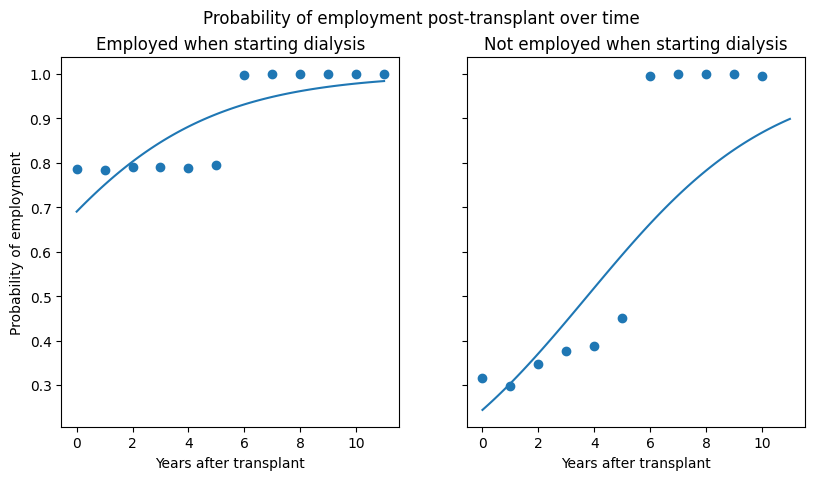

In [129]:
kidpan_followup_data["WORK_INCOME_FOLLOW_UP"] = kidpan_followup_data["WORK_INCOME_FOLLOW_UP"].astype(float)
kidpan_followup_data["WORK_INCOME_TCR"] = kidpan_followup_data["WORK_INCOME_TCR"].astype(float)
employment_model = smf.logit(formula="WORK_INCOME_FOLLOW_UP ~ TIME_SINCE_TRANSPLANT + WORK_INCOME_TCR", data=kidpan_followup_data, missing="drop")
results = employment_model.fit()
print(results.summary())

kidpan_followup_data["TIME_SINCE_TRANSPLANT_YEARGROUPED"] = np.round(kidpan_followup_data["TIME_SINCE_TRANSPLANT"])

fig, axs = plt.subplots(1,2, sharex=True, sharey=True, figsize=plt.figaspect(0.5))
fig.suptitle("Probability of employment post-transplant over time")

annual_followup_means_preemployed = kidpan_followup_data[kidpan_followup_data["WORK_INCOME_TCR"] == 1].groupby("TIME_SINCE_TRANSPLANT_YEARGROUPED").mean(numeric_only=True)
axs[0].scatter(annual_followup_means_preemployed.index, annual_followup_means_preemployed["WORK_INCOME_FOLLOW_UP"])
xvector = np.linspace(0,np.max(annual_followup_means_preemployed.index),100)
axs[0].plot(
    xvector,
    results.predict(
        pd.DataFrame({
            "TIME_SINCE_TRANSPLANT" : xvector,
            "WORK_INCOME_TCR" : np.ones(len(xvector)),
        })
    )
)

axs[0].title.set_text("Employed when starting dialysis")
axs[0].set_xlabel("Years after transplant")
axs[0].set_ylabel("Probability of employment")

annual_followup_means_preunemployed = kidpan_followup_data[kidpan_followup_data["WORK_INCOME_TCR"] == 0].groupby("TIME_SINCE_TRANSPLANT_YEARGROUPED").mean(numeric_only=True)
axs[1].scatter(annual_followup_means_preunemployed.index, annual_followup_means_preunemployed["WORK_INCOME_FOLLOW_UP"])
axs[1].plot(
    xvector,
    results.predict(
        pd.DataFrame({
            "TIME_SINCE_TRANSPLANT" : xvector,
            "WORK_INCOME_TCR" : np.zeros(len(xvector)),
        })
    )
)

axs[1].title.set_text("Not employed when starting dialysis")
axs[1].set_xlabel("Years after transplant")
plt.show()

### Agent Generation and Mortality Rate Demonstration

In [ ]:
def mortality_dialysis(profile, age):
    beta = 0.0064 * profile["GFR"] + 0.0362 * profile["DIAB"]
    if profile["ETHCAT"] == "White":
        return (0.030377 * np.exp(0.035875 * age) + 0.020246) * (1-beta) + beta
    elif profile["ETHCAT"] == "Black":
        return (0.006207 * np.exp(0.052413 * age) + 0.061768) * (1-beta) + beta
    elif profile["ETHCAT"] == "Hispanic":
        return (0.015619 * np.exp(0.042351 * age) + 0.005365) * (1-beta) + beta

def mortality_transplant(profile, age_of_transplant, waitlist_time, age):
    prior_transplant = (profile["NUM_PREV_TX"] > 0)
    # return coeffs[0] * np.exp(coeffs[1] * (age - age_of_transplant)) + coeffs[2] * waitlist_time + coeffs[3] * prior_transplant + coeffs[4] * profile["DIAB"] + coeffs[5] * profile["GFR"]
    return popt[0] * np.exp(popt[1] * age) + popt[2]*age_of_transplant + popt[3]*waitlist_time + popt[4]*prior_transplant + popt[5]*profile["DIAB"] + popt[6]*profile["GFR"] + popt[7]*(profile["ETHCAT"] == "White")


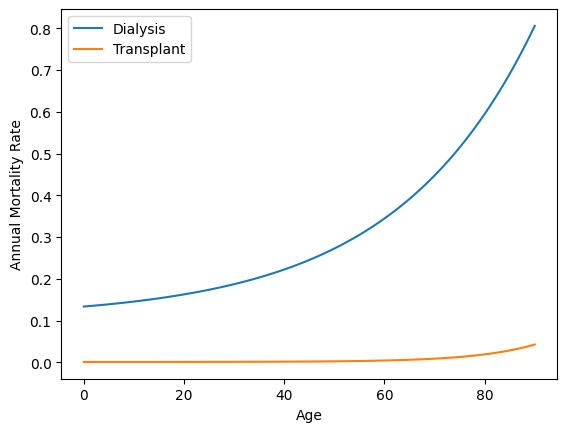

In [ ]:
np.random.seed(1)
profile_index = np.random.randint(0,kidpan_data.shape[0])
profile = kidpan_data.iloc[profile_index]

age_vector = np.linspace(0,90,100)
plt.plot(age_vector, mortality_dialysis(profile, age_vector), label="Dialysis")
plt.plot(age_vector, mortality_transplant(profile, (profile["TX_DATE"] - profile["INIT_DATE"]).days/365 + profile["INIT_AGE"], profile["DAYSWAIT_ALLOC"], age_vector), label="Transplant")

plt.xlabel("Age")
plt.ylabel("Annual Mortality Rate")
plt.legend()
plt.show()